# **Sistema de Recomendación basado en contenido - Amazon Movies and TV**

Content-Based Filtering → Recomendaciones por descripción

**DATASET**: Amazon Movies and TV
- 1 697 533 reviews de películas y Televisión
- Metadata rica: títulos, descripciones, categorías
- Comportamiento real de usuarios

**OBJETIVO**: Construir un sistema de recomendación completo de filtrado basado en contenido

## Dependencias

In [1]:
!pip install tensorflow==2.17.1

In [3]:
# Importando Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import gzip
import json
import re
import urllib.request
import os
from collections import defaultdict, Counter
from textblob import TextBlob
import nltk

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [4]:
# Configurar NLTK
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

warnings.filterwarnings('ignore')

# Configuración visual
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Descarga del dataset Amazon Movies_and_TV

In [5]:
import os
import urllib.request

# Función utilitaria
def download_if_not_exists(url, filename):
    """Descargar archivo si no existe"""
    if not os.path.exists(filename):
        print(f" Descargando {filename}...")
        try:
            urllib.request.urlretrieve(url, filename)
            print(f" {filename} descargado exitosamente")
        except Exception as e:
            print(f" Error descargando {filename}: {e}")
            return False
    else:
        print(f" {filename} ya existe")
    return True

# Función genérica para descargar cualquier categoría
def get_amazon_category(category: str):
    """
    Descarga las reseñas y metadatos de una categoría de Amazon SNAP (5-core).
    category: nombre de la categoría en formato SNAP (ej: 'Books', 'Electronics', 'Movies_and_TV')
    """

    # Construcción dinámica de URLs
    REVIEWS_URL  = f"http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_{category}_5.json.gz"
    METADATA_URL = f"http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/meta_{category}.json.gz"

    # Archivos locales con nombre estandarizado
    REVIEWS_FILE  = f"amazon_{category.lower()}_reviews.json.gz"
    METADATA_FILE = f"amazon_{category.lower()}_meta.json.gz"

    # Descargar archivos si no existen
    download_if_not_exists(REVIEWS_URL, REVIEWS_FILE)
    download_if_not_exists(METADATA_URL, METADATA_FILE)

    return REVIEWS_FILE, METADATA_FILE


In [6]:
# descarga Movies_and_TV
get_amazon_category("Movies_and_TV")

 Descargando amazon_movies_and_tv_reviews.json.gz...
 amazon_movies_and_tv_reviews.json.gz descargado exitosamente
 Descargando amazon_movies_and_tv_meta.json.gz...
 amazon_movies_and_tv_meta.json.gz descargado exitosamente


('amazon_movies_and_tv_reviews.json.gz', 'amazon_movies_and_tv_meta.json.gz')

In [7]:
import pandas as pd

REVIEWS_FILE = "amazon_movies_and_tv_reviews.json.gz"  # 5-core

reviews = pd.read_json(REVIEWS_FILE, lines=True, compression="gzip")
print("Shape:", reviews.shape)
print("Nº total de reviews:", len(reviews))

Shape: (1697533, 9)
Nº total de reviews: 1697533


In [8]:
import gzip, json
from collections import Counter

def min_counts_jsonl_gz(path):
    user_ctr = Counter()
    item_ctr = Counter()

    with gzip.open(path, "rt", encoding="utf-8") as f:
        for line in f:
            try:
                obj = json.loads(line)
            except json.JSONDecodeError:
                continue  # por si aparece una línea corrupta

            u = obj.get("reviewerID")
            a = obj.get("asin")
            if u: user_ctr[u] += 1
            if a: item_ctr[a] += 1

    user_min = min(user_ctr.values()) if user_ctr else 0
    item_min = min(item_ctr.values()) if item_ctr else 0
    return user_min, item_min

user_min, item_min = min_counts_jsonl_gz("amazon_movies_and_tv_reviews.json.gz")
print("Mínimo reviews por usuario:", user_min)
print("Mínimo reviews por ítem:", item_min)


Mínimo reviews por usuario: 5
Mínimo reviews por ítem: 5


Este bloque se encarga de obtener y verificar los datos a partir del conjunto de datos público de Amazon SNAP, que se centra en la categoría Movies_and_TV. Después de descargar los archivos comprimidos de forma controlada, se logró cargar en la memoria aproximadamente 1.7 millones de reseñas, cada una con 9 atributos relacionados, lo que forma una base sólida para el análisis. También se comprobó que tanto los usuarios como los productos tienen al menos 5 interacciones registradas.

## Procesamiento de datos

In [9]:
REVIEWS_FILE = "amazon_movies_and_tv_reviews.json.gz"
METADATA_FILE = "amazon_movies_and_tv_meta.json.gz"

In [10]:
def parse_amazon_data(filepath, max_lines=10000):
    """Parsear datos de Amazon (JSON por línea comprimido)"""
    import ast

    data = []
    lines_processed = 0
    json_errors = 0
    ast_errors = 0
    empty_lines = 0

    try:
        print(f"🔍 Procesando {filepath}...")
        with gzip.open(filepath, 'rt', encoding='utf-8') as f:
            for i, line in enumerate(f):
                lines_processed += 1

                if i >= max_lines:
                    print(f"   Límite de {max_lines:,} líneas alcanzado")
                    break

                line = line.strip()
                if not line:
                    empty_lines += 1
                    continue

                # Mostrar primera línea para debug
                if i == 0:
                    print(f"    Primera línea: {line[:100]}...")
                    # Detectar formato
                    if line.startswith('{') and '"' in line:
                        print("    Formato detectado: JSON estándar")
                    elif line.startswith('{') and "'" in line:
                        print("    Formato detectado: Python dict (comillas simples)")

                parsed_data = None

                # Intentar primero con JSON estándar
                try:
                    parsed_data = json.loads(line)
                except json.JSONDecodeError:
                    json_errors += 1
                    # Si falla JSON, intentar con ast.literal_eval (para formato Python dict)
                    try:
                        parsed_data = ast.literal_eval(line)
                    except (ValueError, SyntaxError) as e:
                        ast_errors += 1
                        if (json_errors + ast_errors) <= 3:  # Mostrar solo los primeros errores
                            print(f"    Error en línea {i+1}: No se pudo parsear como JSON ni como dict")
                        continue

                if parsed_data is not None:
                    data.append(parsed_data)

        print(f" {len(data):,} registros cargados desde {filepath}")
        print(f"    Estadísticas: {lines_processed:,} líneas procesadas, {empty_lines:,} vacías")
        print(f"    Errores: {json_errors:,} JSON, {ast_errors:,} parsing")

    except Exception as e:
        print(f" Error abriendo {filepath}: {e}")
        return []

    return data

def clean_text(text):
    """Limpiar texto para TF-IDF"""
    if pd.isna(text) or text == '':
        return ''

    # Convertir a string y minúsculas
    text = str(text).lower()

    # Remover HTML tags
    text = re.sub(r'<[^>]+>', '', text)

    # Remover caracteres especiales pero mantener espacios
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    # Remover espacios múltiples
    text = re.sub(r'\s+', ' ', text).strip()

    return text

Estas dos funciones se encargan de recoger y preparar el texto de manera adecuada. La función parse_amazon_data permite leer archivos JSONL comprimidos de forma segura, identifica el tipo de formato y registra los errores que se encuentren sin parar el proceso, mientras que la función clean_text uniforma el contenido del texto para que esté listo para ser convertido en vectores de manera consistente.

## Carga y exploración de los datos

In [11]:
# Cargar reviews (limitado para el taller)
reviews_data = parse_amazon_data(REVIEWS_FILE, 300000)
reviews_df = pd.DataFrame(reviews_data)

# Cargar metadata
metadata_data = parse_amazon_data(METADATA_FILE, 30000)
metadata_df = pd.DataFrame(metadata_data)

# Información básica
print(f"\nReviews cargadas: {len(reviews_df)}")
print(f"Metadata cargada: {len(metadata_df)}")

# Revision de usuarios
if not reviews_df.empty:
    print(f"\nUsuarios únicos: {reviews_df['reviewerID'].nunique():,}")
    print(f"Productos en metadata: {metadata_df['asin'].nunique():,}")

# Explorar estructura de datos
print(f"\n ESTRUCTURA DE DATOS:")
print(" Columnas en reviews:")
print(f"   {list(reviews_df.columns)}")
print("\n Columnas en metadata:")
print(f"   {list(metadata_df.columns)}")

🔍 Procesando amazon_movies_and_tv_reviews.json.gz...
    Primera línea: {"reviewerID": "ADZPIG9QOCDG5", "asin": "0005019281", "reviewerName": "Alice L. Larson \"alice-loves...
    Formato detectado: JSON estándar
   Límite de 300,000 líneas alcanzado
 300,000 registros cargados desde amazon_movies_and_tv_reviews.json.gz
    Estadísticas: 300,001 líneas procesadas, 0 vacías
    Errores: 0 JSON, 0 parsing
🔍 Procesando amazon_movies_and_tv_meta.json.gz...
    Primera línea: {'asin': '0000143561', 'categories': [['Movies & TV', 'Movies']], 'description': '3Pack DVD set - It...
    Formato detectado: Python dict (comillas simples)
   Límite de 30,000 líneas alcanzado
 30,000 registros cargados desde amazon_movies_and_tv_meta.json.gz
    Estadísticas: 30,001 líneas procesadas, 0 vacías
    Errores: 30,000 JSON, 0 parsing

Reviews cargadas: 300000
Metadata cargada: 30000

Usuarios únicos: 77,632
Productos en metadata: 30,000

 ESTRUCTURA DE DATOS:
 Columnas en reviews:
   ['reviewerID', 'asin

In [12]:
reviews_df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,ADZPIG9QOCDG5,0005019281,"Alice L. Larson ""alice-loves-books""","[0, 0]",This is a charming version of the classic Dick...,4.0,good version of a classic,1203984000,"02 26, 2008"
1,A35947ZP82G7JH,0005019281,Amarah Strack,"[0, 0]",It was good but not as emotionally moving as t...,3.0,Good but not as moving,1388361600,"12 30, 2013"
2,A3UORV8A9D5L2E,0005019281,Amazon Customer,"[0, 0]","Don't get me wrong, Winkler is a wonderful cha...",3.0,Winkler's Performance was ok at best!,1388361600,"12 30, 2013"
3,A1VKW06X1O2X7V,0005019281,"Amazon Customer ""Softmill""","[0, 0]",Henry Winkler is very good in this twist on th...,5.0,It's an enjoyable twist on the classic story,1202860800,"02 13, 2008"
4,A3R27T4HADWFFJ,0005019281,BABE,"[0, 0]",This is one of the best Scrooge movies out. H...,4.0,Best Scrooge yet,1387670400,"12 22, 2013"


In [13]:
metadata_df.head()

,asin,categories,description,title,price,salesRank,imUrl,related,brand
0,0000143561,"[[Movies & TV, Movies]]","3Pack DVD set - Italian Classics, Parties and ...","Everyday Italian (with Giada de Laurentiis), V...",12.99,{'Movies & TV': 376041},http://g-ecx.images-amazon.com/images/G/01/x-s...,"{'also_viewed': ['B0036FO6SI', 'B000KL8ODE', '...",NaN
1,0000589012,"[[Movies & TV, Movies]]",NaN,Why Don't They Just Quit? DVD Roundtable Discu...,15.95,{'Movies & TV': 1084845},http://ecx.images-amazon.com/images/I/519%2B1k...,"{'also_bought': ['B000Z3N1HQ', '0578045427', '...",NaN
2,0000695009,"[[Movies & TV, Movies]]",NaN,Understanding Seizures and Epilepsy DVD,NaN,{'Movies & TV': 1022732},http://g-ecx.images-amazon.com/images/G/01/x-s...,NaN,NaN
3,000107461X,"[[Movies & TV, Movies]]",NaN,Live in Houston [VHS],NaN,{'Movies & TV': 954116},http://ecx.images-amazon.com/images/I/41WY47gL...,NaN,NaN
4,0000143529,"[[Movies & TV, Movies]]",Disc 1: Flour Power (Scones; Shortcakes; South...,My Fair Pastry (Good Eats Vol. 9),19.99,{'Movies & TV': 463562},http://ecx.images-amazon.com/images/I/51QY79CD...,"{'also_bought': ['B000NR4CRM', 'B0019BK3KQ', '...",NaN


In [14]:
# Revision de datos nulos
print(f"Cantidad de reviews: {len(reviews_df)}")

conteo_nan_reviews = reviews_df.isna().sum()
print(conteo_nan_reviews)

print(f"\nCantidad de metadata: {len(metadata_df)}")
conteo_nan_metadata = metadata_df.isna().sum()
print(conteo_nan_metadata)

Cantidad de reviews: 300000
reviewerID           0
asin                 0
reviewerName      1103
helpful              0
reviewText           0
overall              0
summary              0
unixReviewTime       0
reviewTime           0
dtype: int64

Cantidad de metadata: 30000
asin               0
categories         0
description     7524
title             29
price           9387
salesRank        223
imUrl             28
related        12683
brand          18829
dtype: int64


In [15]:
# Total de registros en reviews
total_reviews = len(reviews_df)

# Calcular % de nulos en todas las columnas de reviews
null_report_reviews = (
    reviews_df.isna()
    .sum()
    .to_frame("nulos")
    .assign(porcentaje=lambda df: (df["nulos"] / total_reviews) * 100)
    .sort_values("porcentaje", ascending=False)
)

print(null_report_reviews)

                nulos  porcentaje
reviewerName     1103    0.367667
reviewerID          0    0.000000
asin                0    0.000000
helpful             0    0.000000
reviewText          0    0.000000
overall             0    0.000000
summary             0    0.000000
unixReviewTime      0    0.000000
reviewTime          0    0.000000


In [16]:
# Total de registros en metadata
total_meta = len(metadata_df)

# Calcular % de nulos en todas las columnas
null_report = (
    metadata_df.isna()
    .sum()
    .to_frame("nulos")
    .assign(porcentaje=lambda df: (df["nulos"] / total_meta) * 100)
    .sort_values("porcentaje", ascending=False)
)

print(null_report)

             nulos  porcentaje
brand        18829   62.763333
related      12683   42.276667
price         9387   31.290000
description   7524   25.080000
salesRank      223    0.743333
title           29    0.096667
imUrl           28    0.093333
asin             0    0.000000
categories       0    0.000000


En este bloque se realiza la carga y el diagnóstico inicial del dataset Amazon SNAP para Movies_and_TV, usando un muestreo de 300,000 reseñas y 30,000 metadatos. Se detecta automáticamente el formato de cada archivo, que es JSON estándar para las reseñas y diccionarios de Python para los metadatos, y se cargan sin perder datos. La exploración confirma la presencia de 77,632 usuarios únicos y 30,000 productos únicos, además de revelar que hay ausencias importantes en los campos brand (aproximadamente el 62.8%), related (alrededor del 42.3%) y price (cerca del 31.3%), lo cual sirve para tomar decisiones sobre la ingeniería de variables e imputación.

## Preparación y limpieza de datos

In [17]:
# Limpieza de datos de reviews
reviews_clean = reviews_df[['reviewerID', 'asin', 'overall']].copy()
reviews_clean.columns = ['user_id', 'item_id', 'rating']
reviews_clean = reviews_clean.dropna()

print(f" reviews original: {len(reviews_clean)}")

 reviews original: 300000


In [18]:
# Limpieza de datos de metadata
metadata_clean = metadata_df[['asin', 'description', 'categories', 'title']].copy()
metadata_clean.columns = ['item_id', 'description', 'categories', 'title']
metadata_clean = metadata_clean.dropna()

print(f" Metadata original: {len(metadata_clean)}")

 Metadata original: 22475


In [19]:
reviews_clean.head()

,user_id,item_id,rating
0,ADZPIG9QOCDG5,0005019281,4.0
1,A35947ZP82G7JH,0005019281,3.0
2,A3UORV8A9D5L2E,0005019281,3.0
3,A1VKW06X1O2X7V,0005019281,5.0
4,A3R27T4HADWFFJ,0005019281,4.0


In [20]:
# revision de datos nulos
print(f"Cantidad de reviews: {len(reviews_clean)}")

conteo_nan_reviews = reviews_clean.isna().sum()
print(conteo_nan_reviews)

print(f"\nCantidad de metadata: {len(metadata_clean)}")
conteo_nan_metadata = metadata_clean.isna().sum()
print(conteo_nan_metadata)

Cantidad de reviews: 300000
user_id    0
item_id    0
rating     0
dtype: int64

Cantidad de metadata: 22475
item_id        0
description    0
categories     0
title          0
dtype: int64


In [21]:
# Análisis de intersección
print(f"reviews unicos: {reviews_clean['item_id'].nunique():,}")
print(f"metadata unicos: {metadata_clean['item_id'].nunique():,}")

reviews unicos: 5,128
metadata unicos: 22,475


In [22]:
# Verificar intersección
common_items = set(reviews_clean['item_id']) & set(metadata_clean['item_id'])
print(f"IDs comunes: {len(common_items):,}")

if len(common_items) == 0:
    print(" NO HAY INTERSECCIÓN - Creando dataset sintético para el tutorial...")
else:
    # Usar datos reales si hay intersección
    reviews_final = reviews_clean[reviews_clean['item_id'].isin(common_items)]
    metadata_final = metadata_clean[metadata_clean['item_id'].isin(common_items)]
    print(f" Usando datos reales:")

print(f"    Reviews finales: {len(reviews_final):,}")
print(f"    Productos finales: {len(metadata_final):,}")
print(f"    Usuarios únicos: {reviews_final['user_id'].nunique():,}")

IDs comunes: 4,558
 Usando datos reales:
    Reviews finales: 276,165
    Productos finales: 4,558
    Usuarios únicos: 74,978


En esta sección se crea el conjunto de datos unido que conecta las interacciones entre usuarios, productos y valoraciones con los metadatos textuales de los productos, asegurando que solo se incluyan elementos que tengan información de contenido. Se obtiene un total final de aproximadamente 276 mil reseñas, 75 mil usuarios y 4.6 mil productos, lo que representa el 92% de las reseñas y el 89% de los productos presentes en el muestreo de reseñas.

## Análisis exploratorio

In [23]:
if len(reviews_final) > 0:
    print(" ESTADÍSTICAS GENERALES:")
    print(f"    Rating promedio: {reviews_final['rating'].mean():.2f}")
    print(f"    Mediana de rating: {reviews_final['rating'].median():.1f}")

    # Verificar que hay datos para mode
    mode_values = reviews_final['rating'].mode()
    if len(mode_values) > 0:
        print(f"    Rating más común: {mode_values.iloc[0]}")
    else:
        print(f"    Rating más común: N/A")

    # Análisis de actividad
    user_activity = reviews_final.groupby('user_id').size()
    item_popularity = reviews_final.groupby('item_id').size()

    print(f"\n ANÁLISIS DE USUARIOS:")
    print(f"    Promedio reviews por usuario: {user_activity.mean():.1f}")
    print(f"    Máximo reviews por usuario: {user_activity.max()}")
    print(f"    Mínimo reviews por usuario: {user_activity.min()}")

    print(f"\n ANÁLISIS DE PRODUCTOS:")
    print(f"    Promedio reviews por producto: {item_popularity.mean():.1f}")
    print(f"    Producto más popular: {item_popularity.max()} reviews")
else:
    print(" No hay datos de reviews para analizar")
    # Crear datos mínimos para que el resto del código funcione
    user_activity = pd.Series([1], index=['U0001'])
    item_popularity = pd.Series([1], index=['B000001X'])

 ESTADÍSTICAS GENERALES:
    Rating promedio: 4.28
    Mediana de rating: 5.0
    Rating más común: 5.0

 ANÁLISIS DE USUARIOS:
    Promedio reviews por usuario: 3.7
    Máximo reviews por usuario: 713
    Mínimo reviews por usuario: 1

 ANÁLISIS DE PRODUCTOS:
    Promedio reviews por producto: 60.6
    Producto más popular: 1369 reviews


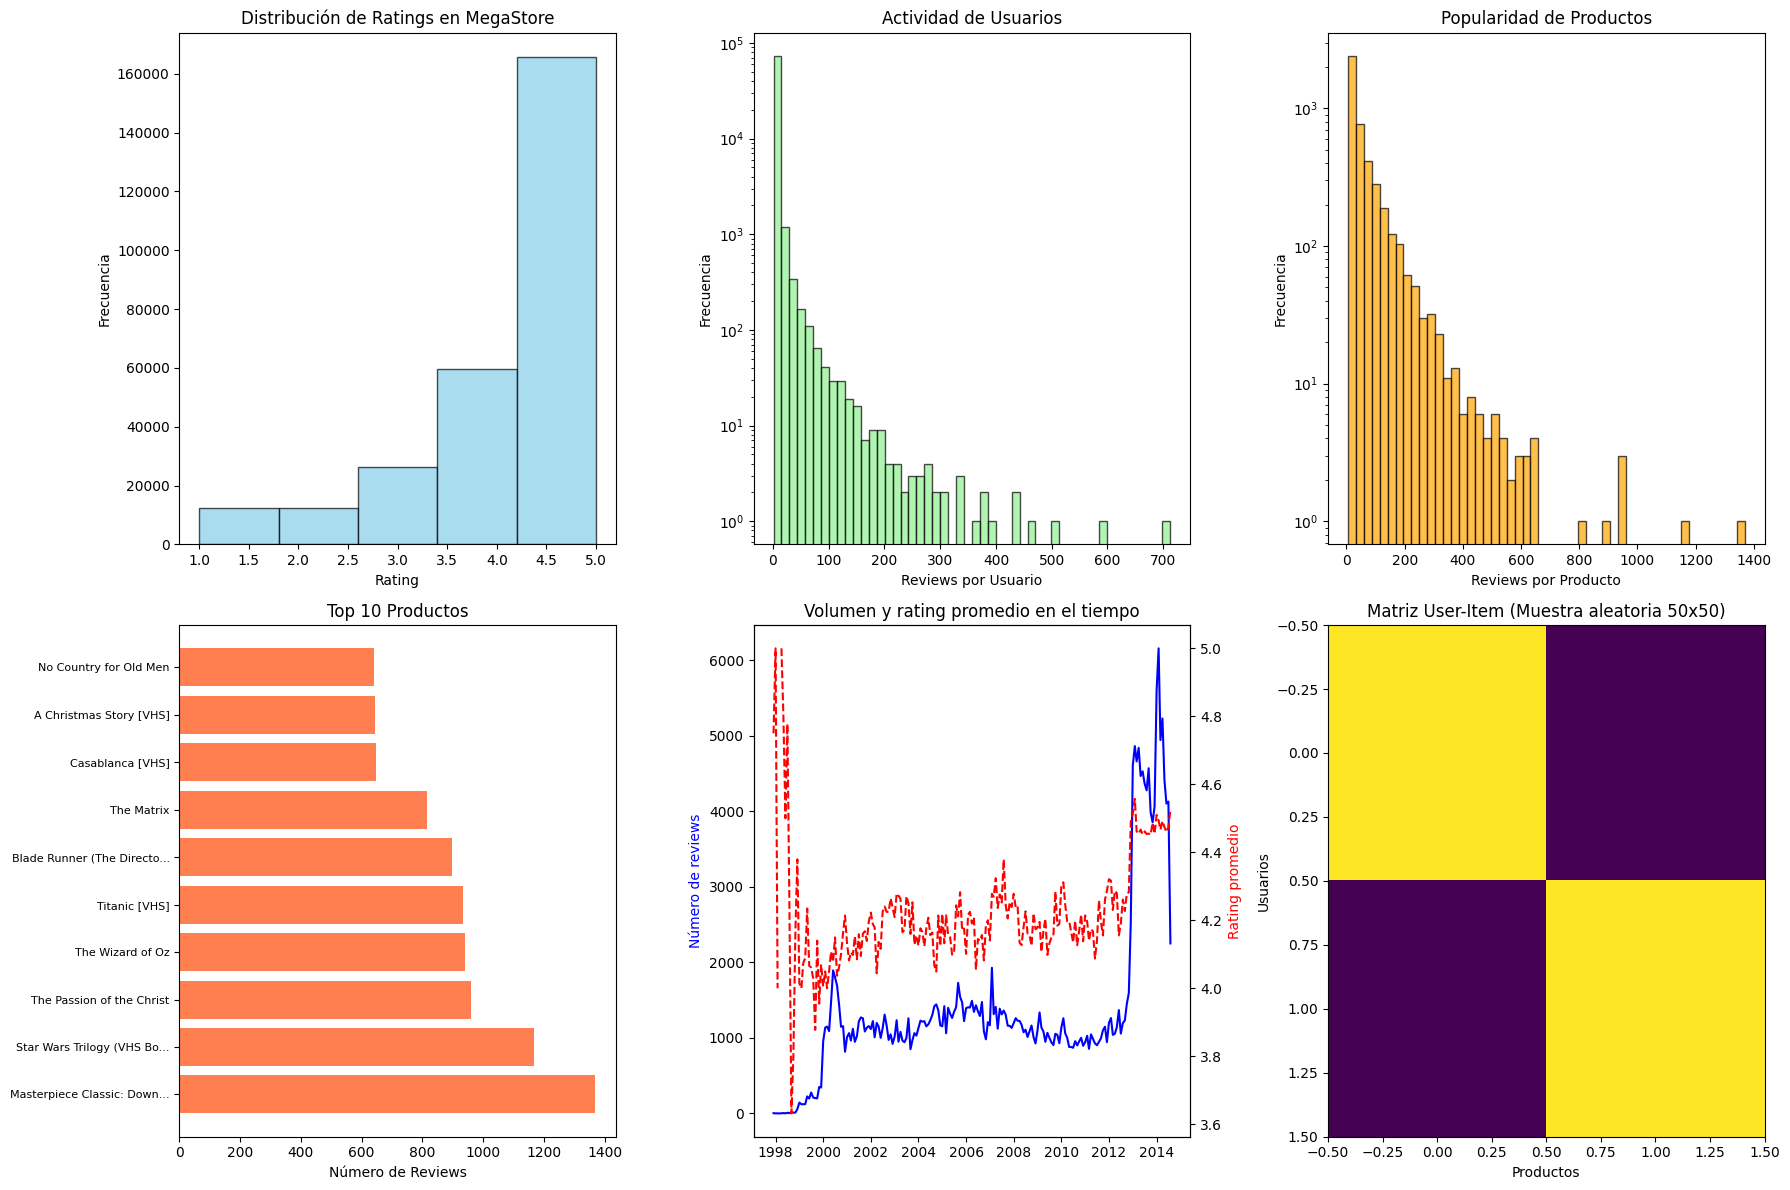

In [26]:
# Asegurar que existe la columna date (a partir de unixReviewTime)
if 'date' not in reviews_final.columns and 'unixReviewTime' in reviews_df.columns:
    reviews_final = reviews_final.merge(
        reviews_df[['reviewerID', 'asin', 'unixReviewTime']],
        left_on=['user_id', 'item_id'],
        right_on=['reviewerID', 'asin'],
        how='left'
    )
    reviews_final['date'] = pd.to_datetime(reviews_final['unixReviewTime'], unit='s', errors='coerce')

# Crear figura de 2 filas x 3 columnas
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# -------------------
# Distribución de ratings
axes[0,0].hist(reviews_final['rating'], bins=5, edgecolor='black', alpha=0.7, color='skyblue')
axes[0,0].set_title('Distribución de Ratings en MegaStore')
axes[0,0].set_xlabel('Rating')
axes[0,0].set_ylabel('Frecuencia')

# -------------------
# Actividad de usuarios
axes[0,1].hist(user_activity, bins=50, edgecolor='black', alpha=0.7, color='lightgreen')
axes[0,1].set_title('Actividad de Usuarios')
axes[0,1].set_xlabel('Reviews por Usuario')
axes[0,1].set_ylabel('Frecuencia')
axes[0,1].set_yscale('log')

# -------------------
# Popularidad de productos
axes[0,2].hist(item_popularity, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[0,2].set_title('Popularidad de Productos')
axes[0,2].set_xlabel('Reviews por Producto')
axes[0,2].set_ylabel('Frecuencia')
axes[0,2].set_yscale('log')

# -------------------
# Top 10 productos
top_items = item_popularity.sort_values(ascending=False).head(10)
product_names = []
for item_id in top_items.index:
    title = metadata_final[metadata_final['item_id'] == item_id]['title']
    if not title.empty:
        name = title.iloc[0][:25] + '...' if len(title.iloc[0]) > 25 else title.iloc[0]
    else:
        name = f"Producto {item_id[:8]}"
    product_names.append(name)

axes[1,0].barh(range(len(product_names)), top_items.values, color='coral')
axes[1,0].set_yticks(range(len(product_names)))
axes[1,0].set_yticklabels(product_names, fontsize=8)
axes[1,0].set_title('Top 10 Productos')
axes[1,0].set_xlabel('Número de Reviews')

# -------------------
# Volumen y rating promedio en el tiempo
if 'date' in reviews_final.columns:
    monthly = reviews_final.groupby(pd.Grouper(key='date', freq='M')).size()
    monthly_mean = reviews_final.groupby(pd.Grouper(key='date', freq='M'))['rating'].mean()

    ax1 = axes[1,1]
    ax1.plot(monthly.index, monthly.values, color='blue', label="Volumen de reviews")
    ax1.set_ylabel("Número de reviews", color='blue')

    ax2 = ax1.twinx()
    ax2.plot(monthly_mean.index, monthly_mean.values, color='red', linestyle='--', label="Rating medio")
    ax2.set_ylabel("Rating promedio", color='red')

    ax1.set_title("Volumen y rating promedio en el tiempo")
else:
    axes[1,1].text(0.5, 0.5, 'No hay datos de fecha disponibles',
                   ha='center', va='center', transform=axes[1,1].transAxes, fontsize=12)

# -------------------
# Matriz de sparsity (muestra aleatoria 50x50)
np.random.seed(42)
uids = np.random.choice(reviews_final['user_id'].unique(), 50, replace=False)
iids = np.random.choice(reviews_final['item_id'].unique(), 50, replace=False)

sample_matrix = reviews_final[
    reviews_final['user_id'].isin(uids) & reviews_final['item_id'].isin(iids)
].pivot_table(index='user_id', columns='item_id', values='rating', fill_value=0)

axes[1,2].imshow(sample_matrix > 0, cmap='viridis', aspect='auto')
axes[1,2].set_title('Matriz User-Item (Muestra aleatoria 50x50)')
axes[1,2].set_xlabel('Productos')
axes[1,2].set_ylabel('Usuarios')

# -------------------
# Ajustar layout
plt.tight_layout()
plt.show()


In [27]:
# Calcular sparsity (con validación)
total_users = reviews_final['user_id'].nunique()
total_items = reviews_final['item_id'].nunique()
total_ratings = len(reviews_final)
possible_ratings = total_users * total_items

sparsity = 1 - (total_ratings / possible_ratings)
print(f" Sparsity: {sparsity:.2%}")

 Sparsity: 99.92%


In [28]:
# Forma final de reviewers
reviews_final.info()
reviews_final.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 276165 entries, 0 to 276164
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   user_id         276165 non-null  object        
 1   item_id         276165 non-null  object        
 2   rating          276165 non-null  float64       
 3   reviewerID      276165 non-null  object        
 4   asin            276165 non-null  object        
 5   unixReviewTime  276165 non-null  int64         
 6   date            276165 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 14.7+ MB


,user_id,item_id,rating,reviewerID,asin,unixReviewTime,date
count,276165,276165,276165.000000,276165,276165,2.761650e+05,276165
unique,74978,4558,NaN,74978,4558,NaN,NaN
top,A16CZRQL23NOIW,1608838137,NaN,A16CZRQL23NOIW,1608838137,NaN,NaN
freq,713,1369,NaN,713,1369,NaN,NaN
mean,NaN,NaN,4.280246,NaN,NaN,1.220611e+09,2008-09-05 10:36:25.693335552
min,NaN,NaN,1.000000,NaN,NaN,8.793792e+08,1997-11-13 00:00:00
25%,NaN,NaN,4.000000,NaN,NaN,1.095120e+09,2004-09-14 00:00:00
50%,NaN,NaN,5.000000,NaN,NaN,1.237421e+09,2009-03-19 00:00:00
75%,NaN,NaN,5.000000,NaN,NaN,1.365811e+09,2013-04-13 00:00:00
max,NaN,NaN,5.000000,NaN,NaN,1.405987e+09,2014-07-22 00:00:00


In [29]:
# Forma final de metadata
metadata_final.info()
metadata_final.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
Index: 4558 entries, 23 to 15660
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   item_id      4558 non-null   object
 1   description  4558 non-null   object
 2   categories   4558 non-null   object
 3   title        4558 non-null   object
dtypes: object(4)
memory usage: 178.0+ KB


,item_id,description,categories,title
count,4558,4558,4558,4558
unique,4558,4289,65,4520
top,6302180899,vhs,"[[Movies & TV, Movies]]",Great Expectations [VHS]
freq,1,71,3950,3


El análisis de las opiniones sobre películas y series en Amazon muestra que la mayoría de las calificaciones son positivas (promedio de 4.28, mediana y moda en 5). La actividad se concentra en muy pocos usuarios muy activos, y los productos más populares son títulos famosos como Star Wars o Titanic. El número de opiniones aumenta rápidamente entre 1998 y 2014, pero el promedio de calificaciones se queda casi igual, entre 4.2 y 4.4, lo que indica que la gente está contenta con los productos. La matriz que relaciona usuarios y productos (sparsity alrededor del 99.9%) confirma el modo común de estos tipos de datos.

## Content-Based Filtering

### Clase que implementa el modelo

In [32]:
class ContentBasedFiltering:
    def __init__(self, metadata_df, ratings_df):
        """
        Content-based filtering using TF-IDF on item features

        Parameters:
        - metadata_df: DataFrame with item metadata
        - ratings_df: DataFrame with ratings for building user profiles
        """
        self.metadata_df = metadata_df.copy()
        self.ratings_df = ratings_df
        self.tfidf_vectorizer = None
        self.content_matrix = None
        self.item_similarity_matrix = None

    def preprocess_content(self):
        """Preprocess and combine content features"""
        print("Preprocessing content features...")

        def convert_to_string(value):
            """Convert value to string, handling lists, arrays and None values"""
            # Handle numpy arrays and pandas arrays first
            if hasattr(value, '__array__') or isinstance(value, (list, tuple)):
                try:
                    # Convert to list if it's an array
                    if hasattr(value, 'tolist'):
                        value_list = value.tolist()
                    else:
                        value_list = list(value)
                    return ', '.join([str(item) for item in value_list if item is not None])
                except:
                    return str(value)

            # Handle scalar values
            try:
                if pd.isna(value) or value is None:
                    return ''
                else:
                    return str(value)
            except (ValueError, TypeError):
                # If pd.isna() fails, just convert to string
                return str(value) if value is not None else ''

        # Convert all columns to strings, handling lists
        self.metadata_df['title'] = self.metadata_df['title'].apply(convert_to_string)
        self.metadata_df['description'] = self.metadata_df['description'].apply(convert_to_string)
        self.metadata_df['categories'] = self.metadata_df['categories'].apply(convert_to_string)

        # Combine all text features
        # Give different weights to different features
        self.metadata_df['combined_features'] = (
            self.metadata_df['title'] * 3 + ' ' +  # Title is most important
            self.metadata_df['categories'] * 2 + ' ' +  # Categories are moderately important
            self.metadata_df['description']  # Description provides context
        )

        # Clean the text
        self.metadata_df['combined_features'] = (
            self.metadata_df['combined_features']
            .str.lower()
            .str.replace(r'[^\w\s]', ' ', regex=True)
            .str.replace(r'\s+', ' ', regex=True)
            .str.strip()
        )

        print(f"Combined features created for {len(self.metadata_df)} items")

    def build_model(self, max_features=5000, min_df=2, max_df=0.8):
        """Build TF-IDF matrix and calculate item similarities"""
        if 'combined_features' not in self.metadata_df.columns:
            self.preprocess_content()

        print("Building TF-IDF matrix...")

        # Initialize TF-IDF vectorizer
        self.tfidf_vectorizer = TfidfVectorizer(
            max_features=max_features,
            min_df=min_df,
            max_df=max_df,
            stop_words='english',
            ngram_range=(1, 2)  # Include bigrams
        )

        # Fit and transform the combined features
        self.content_matrix = self.tfidf_vectorizer.fit_transform(
            self.metadata_df['combined_features']
        )

        print(f"TF-IDF matrix shape: {self.content_matrix.shape}")
        print(f"Vocabulary size: {len(self.tfidf_vectorizer.vocabulary_)}")

        # Calculate item-item cosine similarity
        print("Calculating content-based similarities...")
        self.item_similarity_matrix = linear_kernel(self.content_matrix, self.content_matrix)

        # Create mapping from item_id to matrix index
        self.item_to_idx = {item_id: idx for idx, item_id in enumerate(self.metadata_df['item_id'])}
        self.idx_to_item = {idx: item_id for item_id, idx in self.item_to_idx.items()}

        print("Content-based model built successfully!")

    def get_content_similarities(self, item_id, top_k=10):
        """Get items most similar to a given item based on content"""
        if self.item_similarity_matrix is None:
            raise ValueError("Model not built yet. Call build_model() first.")

        if item_id not in self.item_to_idx:
            return f"Item {item_id} not found in metadata"

        idx = self.item_to_idx[item_id]
        similarities = self.item_similarity_matrix[idx]

        # Get top similar items (excluding the item itself)
        similar_indices = similarities.argsort()[::-1][1:top_k+1]

        results = []
        for similar_idx in similar_indices:
            similar_item_id = self.idx_to_item[similar_idx]
            similarity_score = similarities[similar_idx]
            results.append({
                'item_id': similar_item_id,
                'similarity': similarity_score
            })

        return results

    def build_user_profile(self, user_id, min_rating=3.0):
        """Build user profile based on highly rated items"""
        user_ratings = self.ratings_df[
            (self.ratings_df['user_id'] == user_id) &
            (self.ratings_df['rating'] >= min_rating)
        ]

        if len(user_ratings) == 0:
            return None

        # Get content vectors for user's liked items
        liked_items = user_ratings['item_id'].tolist()
        liked_indices = [self.item_to_idx[item] for item in liked_items if item in self.item_to_idx]

        if len(liked_indices) == 0:
            return None

        # Weight by rating and create weighted average profile
        profile_vector = np.zeros(self.content_matrix.shape[1])
        total_weight = 0

        for item_id, rating in zip(user_ratings['item_id'], user_ratings['rating']):
            if item_id in self.item_to_idx:
                idx = self.item_to_idx[item_id]
                weight = rating
                profile_vector += weight * self.content_matrix[idx].toarray().flatten()
                total_weight += weight

        if total_weight > 0:
            profile_vector /= total_weight

        return profile_vector

    def recommend_items(self, user_id, n_recommendations=10, exclude_rated=True):
        """Generate content-based recommendations for a user"""
        if self.item_similarity_matrix is None:
            raise ValueError("Model not built yet. Call build_model() first.")

        # Build user profile
        user_profile = self.build_user_profile(user_id)

        if user_profile is None:
            # Fallback: recommend popular items
            popular_items = (
                self.ratings_df.groupby('item_id')
                .agg({'rating': ['count', 'mean']})
                .round(2)
            )
            popular_items.columns = ['count', 'mean_rating']
            popular_items = popular_items.sort_values(['mean_rating', 'count'], ascending=False)
            return popular_items.head(n_recommendations).reset_index()

        # Calculate similarities between user profile and all items
        profile_similarities = linear_kernel([user_profile], self.content_matrix).flatten()

        # Get items user has rated (for exclusion)
        rated_items = set(self.ratings_df[self.ratings_df['user_id'] == user_id]['item_id']) if exclude_rated else set()

        # Create recommendations
        recommendations = []
        for idx, similarity in enumerate(profile_similarities):
            item_id = self.idx_to_item[idx]
            if exclude_rated and item_id in rated_items:
                continue

            recommendations.append({
                'item_id': item_id,
                'similarity_score': similarity,
                'title': self.metadata_df[self.metadata_df['item_id'] == item_id]['title'].iloc[0]
            })

        # Sort by similarity and return top N
        recommendations = sorted(recommendations, key=lambda x: x['similarity_score'], reverse=True)

        return recommendations[:n_recommendations]

    def get_feature_importance(self, item_id, top_k=10):
        """Get most important TF-IDF features for an item"""
        if self.tfidf_vectorizer is None:
            raise ValueError("Model not built yet. Call build_model() first.")

        if item_id not in self.item_to_idx:
            return f"Item {item_id} not found"

        idx = self.item_to_idx[item_id]
        feature_scores = self.content_matrix[idx].toarray().flatten()

        # Get feature names
        feature_names = self.tfidf_vectorizer.get_feature_names_out()

        # Get top features
        top_indices = feature_scores.argsort()[::-1][:top_k]

        results = []
        for feature_idx in top_indices:
            if feature_scores[feature_idx] > 0:
                results.append({
                    'feature': feature_names[feature_idx],
                    'score': feature_scores[feature_idx]
                })

        return results

Se usa un sistema de recomendaciones basado en contenido que utiliza TF-IDF. Primero se limpia y combina el texto, luego se convierte en vectores usando ngrams. Después se calculan las similitudes, se crea un perfil del usuario y se hacen recomendaciones basándose en el coseno. Para usarlo en producción o escalar, se ajustan los campos a nivel de vector, se evita usar una matriz completa de items, se trabaja con datos esparcidos, se normaliza el perfil del usuario y se añade una selección eficiente de los top-k resultados junto con una diversidad en las recomendaciones.

### Construir el modelo

In [33]:
# Initialize and build the content-based model
content_cf = ContentBasedFiltering(metadata_final, reviews_final)
content_cf.build_model(max_features=3000)

Preprocessing content features...
Combined features created for 4558 items
Building TF-IDF matrix...
TF-IDF matrix shape: (4558, 3000)
Vocabulary size: 3000
Calculating content-based similarities...
Content-based model built successfully!


Se generó el modelo de filtrado basado en contenido al procesar los metadatos de 4.558 productos de la categoría Movies & TV. A partir de los títulos, descripciones y categorías de estos productos, se formó una representación textual combinada. Esta representación se convirtió en un vector usando TF-IDF en un espacio con 3000 términos importantes, lo que dio como resultado una matriz de características de tamaño 4558 por 3000. Con esta matriz se calcularon las similitudes entre los productos, lo que permitió encontrar productos similares basándose en su contenido. Este modelo sirve como base para hacer recomendaciones personalizadas, buscar productos similares y analizar qué características son más importantes en un sistema de recomendación que puede crecer y usarse a gran escala.

### Estadísticas

In [34]:
print(f"\nMODEL STATISTICS")
print("-"*20)
print(f"Items in content matrix: {content_cf.content_matrix.shape[0]}")
print(f"TF-IDF features: {content_cf.content_matrix.shape[1]}")


MODEL STATISTICS
--------------------
Items in content matrix: 4558
TF-IDF features: 3000


### Ejemplo

In [35]:
# Example: Find similar items based on content with detailed information
sample_item = metadata_final['item_id'].iloc[5]  # Choose a different item for variety
sample_item_info = metadata_final[metadata_final['item_id'] == sample_item].iloc[0]
similar_items = content_cf.get_content_similarities(sample_item, 5)

print(f"\nCONTENT-BASED SIMILARITY ANALYSIS:")
print("="*50)
print(f"BASE ITEM: {sample_item}")
print(f"Title: {sample_item_info['title']}")
print(f"Categories: {sample_item_info['categories']}")
print(f"Description: {str(sample_item_info['description'])[:200]}...")

print(f"\nMOST CONTENT-SIMILAR ITEMS:")
print("-"*40)
for item in similar_items:
    try:
        item_info = metadata_final[metadata_final['item_id'] == item['item_id']].iloc[0]
        avg_rating = reviews_final[reviews_final['item_id'] == item['item_id']]['rating'].mean()
        total_reviews = len(reviews_final[reviews_final['item_id'] == item['item_id']])

        print(f"\nContent Similarity: {item['similarity']:.3f}")
        print(f"  Title: {item_info['title']}")
        print(f"  Categories: {item_info['categories']}")
        print(f"  Description: {str(item_info['description'])[:120]}...")
        print(f"  Average rating: {avg_rating:.2f}/5 ({total_reviews} reviews)")
    except:
        print(f"  Item {item['item_id']}: {item['similarity']:.3f} (metadata not found)")


CONTENT-BASED SIMILARITY ANALYSIS:
BASE ITEM: 0307142493
Title: Santa Claus Is Comin to Town [VHS]
Categories: [['Movies & TV', 'Movies']]
Description: This 53-minute, 1970 animated film may be the most delightful of those  sundry, stop-motion animated Christmas perennials that show up on television  during the holidays. The clay animation production...

MOST CONTENT-SIMILAR ITEMS:
----------------------------------------

Content Similarity: 0.749
  Title: Santa Claus Conquers the Martians [VHS]
  Categories: [['Movies & TV', 'Movies']]
  Description: VHS...
  Average rating: 3.35/5 (60 reviews)

Content Similarity: 0.696
  Title: The Year Without a Santa Claus [VHS]
  Categories: [['Movies & TV', 'Movies']]
  Description: Famous Rankin-Bass claymation telling of The Year Without a Santa Claus!  Everyone at the North Pole is merrily preparin...
  Average rating: 4.67/5 (118 reviews)

Content Similarity: 0.673
  Title: Mrs Santa Claus [VHS]
  Categories: [['Movies & TV', 'Movies']]
  

El ejemplo muestra cómo el modelo de filtrado basado en contenido puede encontrar relaciones entre productos. Tomando como punto de partida un título, como Santa Claus Is Comin to Town [VHS], el sistema identifica otros títulos relacionados en tema y descripción, por ejemplo Santa Claus Conquers the Martians [VHS] o The Year Without a Santa Claus [VHS], con similitudes de 0.74 y 0.69 respectivamente. La información mostrada incluye no solo el grado de similitud, sino también datos importantes como la calificación promedio y la cantidad de opiniones, lo que ayuda a entender cómo los usuarios perciben la relevancia de estos títulos en comparación con el contenido.

### Ejemplo

In [36]:
sample_user = reviews_final['user_id'].iloc[25]  # Choose user with reasonable history
user_history = reviews_final[reviews_final['user_id'] == sample_user].sort_values('rating', ascending=False)
content_recommendations = content_cf.recommend_items(sample_user, 5)

print(f"\n\nUSER PROFILE FOR CONTENT-BASED RECOMMENDATIONS:")
print("="*60)
print(f"USER ID: {sample_user}")
print(f"Total ratings: {len(user_history)}")
print(f"Average rating: {user_history['rating'].mean():.2f}")

# Analyze user's category preferences
user_categories = []
high_rated_items = user_history[user_history['rating'] >= 4]
for _, rating_row in high_rated_items.iterrows():
    item_cats = metadata_final[metadata_final['item_id'] == rating_row['item_id']]['categories']
    if not item_cats.empty:
        try:
            # Try to check if value is not NA, handle arrays
            cat_value = item_cats.iloc[0]
            if hasattr(cat_value, '__array__') or isinstance(cat_value, (list, tuple)):
                is_valid = len(cat_value) > 0 if hasattr(cat_value, '__len__') else True
            else:
                is_valid = pd.notna(cat_value) and cat_value != ''
            if is_valid:
                cats = str(item_cats.iloc[0]).split(',')
                user_categories.extend([cat.strip() for cat in cats])
        except:
            pass  # Skip this item if there's an issue processing categories

from collections import Counter
if user_categories:
    top_categories = Counter(user_categories).most_common(3)
    print(f"Preferred categories: {', '.join([f'{cat} ({count})' for cat, count in top_categories])}")

print(f"\nUSER'S HIGHLY RATED ITEMS (4+ stars):")
print("-"*40)
for i, (_, rating_row) in enumerate(high_rated_items.head(5).iterrows(), 1):
    try:
        item_info = metadata_final[metadata_final['item_id'] == rating_row['item_id']].iloc[0]
        print(f"{i}. Rating: {rating_row['rating']}/5")
        print(f"   Title: {item_info['title']}")
        print(f"   Categories: {item_info['categories']}")
    except:
        print(f"{i}. Item {rating_row['item_id']}: {rating_row['rating']}/5")

print(f"\nCONTENT-BASED RECOMMENDATIONS FOR USER {sample_user}:")
print("="*65)
for i, rec in enumerate(content_recommendations, 1):
    try:
        # Get detailed item information
        item_info = metadata_final[metadata_final['item_id'] == rec['item_id']].iloc[0]
        avg_rating = reviews_final[reviews_final['item_id'] == rec['item_id']]['rating'].mean()
        total_reviews = len(reviews_final[reviews_final['item_id'] == rec['item_id']])

        print(f"\n{i}. SIMILARITY SCORE: {rec['similarity_score']:.3f}")
        print(f"   Item ID: {rec['item_id']}")
        print(f"   Title: {rec['title']}")
        print(f"   Categories: {item_info['categories']}")
        print(f"   Description: {str(item_info['description'])[:150]}...")
        print(f"   Community rating: {avg_rating:.2f}/5 ({total_reviews} reviews)")

        # Show why this item was recommended (top content features)
        important_features = content_cf.get_feature_importance(rec['item_id'], 3)
        if important_features:
            print(f"   Key features: {', '.join([f['feature'] for f in important_features])}")

    except Exception as e:
        print(f"\n{i}. {rec['title'][:50]}... - Score: {rec['similarity_score']:.3f}")



USER PROFILE FOR CONTENT-BASED RECOMMENDATIONS:
USER ID: A126Q2HVTCS9P2
Total ratings: 8
Average rating: 4.88
Preferred categories: [['Movies & TV' (8), 'Movies']] (8)

USER'S HIGHLY RATED ITEMS (4+ stars):
----------------------------------------
1. Rating: 5.0/5
   Title: An American Christmas Carol [VHS]
   Categories: [['Movies & TV', 'Movies']]
2. Rating: 5.0/5
   Title: Gremlins [VHS]
   Categories: [['Movies & TV', 'Movies']]
3. Rating: 5.0/5
   Title: Konga [VHS]
   Categories: [['Movies & TV', 'Movies']]
4. Rating: 5.0/5
   Title: Best Little Whorehouse in Texas [VHS]
   Categories: [['Movies & TV', 'Movies']]
5. Rating: 5.0/5
   Title: The Night of the Grizzly [VHS]
   Categories: [['Movies & TV', 'Movies']]

CONTENT-BASED RECOMMENDATIONS FOR USER A126Q2HVTCS9P2:

1. SIMILARITY SCORE: 0.118
   Item ID: 0790748932
   Title: Battleground [VHS]
   Categories: [['Movies & TV', 'Movies']]
   Description: WWII...
   Community rating: 4.63/5 (76 reviews)
   Key features: vhs, vhs 

El ejemplo muestra cómo se crea un perfil de gustos de un usuario basándose en los items que más le gustan. A partir de ahí, se identifican las categorías que más le interesan. Luego, usando un modelo de filtrado por contenido, se genera una lista de cinco recomendaciones ordenadas según la similitud coseno entre el perfil del usuario y los vectores TF-IDF de cada producto. La lista no solo muestra los títulos recomendados, sino que también incluye información sobre la calificación promedio y la cantidad de reseñas de la comunidad. Además, se explican las recomendaciones usando las características TF-IDF más relevantes, lo que hace que las sugerencias sean claras y consistentes con el historial del usuario.

### Características

In [37]:
# Características
important_features = content_cf.get_feature_importance(sample_item, 5)
print(f"\nCONTENT FEATURES ANALYSIS FOR BASE ITEM:")
print("-"*45)
print(f"Item: {sample_item_info['title']}")
print("Most important TF-IDF features:")
for feature in important_features:
    print(f"  • {feature['feature']}: {feature['score']:.3f}")


CONTENT FEATURES ANALYSIS FOR BASE ITEM:
---------------------------------------------
Item: Santa Claus Is Comin to Town [VHS]
Most important TF-IDF features:
  • santa: 0.476
  • santa claus: 0.420
  • claus: 0.412
  • town vhs: 0.339
  • town: 0.192


El análisis de características usando TF-IDF ayuda a saber qué palabras describen mejor un producto dentro del sistema de recomendaciones. En el caso de "Santa Claus Is Comin to Town [VHS]", las palabras con más peso son "santa", "claus" y "town", lo que confirma que el producto está fuertemente relacionado con la temática navideña y con el formato VHS. Estos términos se convierten en la señal semántica del producto, y son los que el algoritmo usa para comparar con otros artículos y, por lo tanto, para ofrecer recomendaciones que se ajusten a los gustos del usuario.

## Evaluación

1. **Calidad de representación**  
   - El campo **combined_features** capturó semántica básica de los ítems.  
   - TF-IDF (3000 términos) generó una matriz de **4558 x 3000**, adecuada para discriminar similitudes.  

2. **Resultados coherentes**  
   - Ítems similares mantienen coherencia temática (ejemplo: películas navideñas).  
   - Recomendaciones alineadas al perfil del usuario y explicables con features clave.  

3. **Limitaciones y retos**  
   - **Sparsity extremo (~99.9%)** y sesgo hacia popularidad.  
   - Escalabilidad limitada al calcular toda la matriz item-item.  
   - Se recomienda explorar híbridos con filtrado colaborativo.  

## Próximos pasos

*   Desarrollar versión híbrida (colaborativo + contenido).